# Multivariate Time Series Analysis using LSTM

## Summarization of Findings:
The business problem being solved in this project is that Royal Caribbean wants to cut down on energy consumption, and factors such as indoor and outdoor temperature and humidity, as well as other weather factors, play a large role in energy consumption (as a lot of energy goes into regulating temperature inside a ship). Thus we set out to predict energy consumption based on a multivariate time series with 24 features. In order to do so, we will leverage the computing powers of a Long-Short-Term Memory neural network. LSTM was a great choice for this problem because, unlike classic linear regression models, it handles multivariate timeseries data very well. I initially tried a VAR and VARMA model on the data but found that it was not as robust as LSTM, so I put that aside for the time being. I used the RMSE score or testing and training data as a main indicator of success in the models. The models with unaggregated data and hourly aggregated data were the best performers, and they consistantly had low RMSE scores, with very similar testing and training scores, indicating that there is not significant over or under fitting. 


### How and why I chose the model and parameters

Long-short term memory (LSTM) is a type of Recurrent Neural Network (RNN) that is best suited for classifying, processing and predicting time series data, especially multivariate time series data like we have. The beauty in an LSTM model over other RNNs is that they solve the vanishing gradients problem that occurs when back propogating, since LSTM untis allow gradients to flow through the network unchanged (the error remains in the LSTM unit's cell). The reason I chose this model over a linear regression model like ARIMA, VAR, or VARMA is because after testing my data on all 4 models, I quickly found that LSTM far outperformed the other models in a much shorter amount of time. This leads me to discussing the next point: picking parameters. The parameters of interest in this model were epochs, lookback, and units of RNN (ofcourse there are other hyperparameters involved, but these were the ones I focused on tuning). Based off of prior knowledge, I came into testing with epoch = 50, lookback = 1 and unit = 1. I had fairly good results, but wanted to see if I could do better. No matter how much I increased my parameters, the payoff was not enough to warrant the added computation time, so I decided to stick to these for now.


### Literary Review of Comparitively Similar Data

In the paper “The Added Value of Advanced Feature Engineering and Selection for Machine Learning Models for Spacecraft behavior prediction” , Ying Gu and authors describe their method for predicting power produced by solar panels of the Mars Express Orbiter using a multivariate time series, which is quite similar to the data set we have. The biggest difference between our data is their data was multi-targeted: they had 33 unique power lines that they wanted to predict power consumption for, whereas we have just one cruise ship’s set of data to predict power consumption from. Gu and fellow authors focused very heavily on feature extraction to help reduce the higher RMSE value of certain power lines that showed abnormally high RMSE values. They were able to reduce these power lines to the 40 best features, and then fed the features into the ensemble model of RF and XGBoost, which they trained on each of their 33 power lines. 

![image](FEAT_results.png)
Source: https://arc.aiaa.org/doi/pdf/10.2514/6.2018-2561?download=true



### In this notebook, you can expect to find the following topics:

    -We will write a function which takes a data set and trains and fits a LSTM neural network to our data, printing out a plot showing the error after each epoch and another plot showing the actual vs. predicted energy consumption for our test data. 
    - We will look at correlation between total energy consumption and each feature 
    - We will do feature extraction and see how our model behaves on a smaller dimensionality.
    - We will analyze data features of our dataset including hourly and daily data and compare how times of day and days of the week differ in energy consumption
 

In [167]:
#import all dependencies
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt 
import seaborn as sns


# convert series to supervised learning to use as input for our network
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

#our neural network
def network(dataset, n_train_hours, lookback = 1, n_features=24, epoch=50, batch_sz=72):
    '''
    Parameters:
    -n_train_hours specifies amount of data to set for training 
    -lookback specify the number of lag samples
    -n_features specifies the number of features in dataset
    -epoch specifies how many epochs to run the LSTM on
    -batch_sz limits the number of samples to be shown to the network before a weight update can be performed in our LSTM.
    
    '''
    
    values = dataset.values
    # ensure all data is float
    values = values.astype('float32')
    
    # Normalizing the input data using MinMaxScaler so all input features are on a scale from 0 to 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)

     

    # frame as supervised learning
    reframed = series_to_supervised(scaled, lookback, 1)
    #only want to predict one feature, TotalConsp
    reframed.drop(reframed.columns[[i for i in range(n_features,n_features*2)]], axis=1, inplace=True)

    #make sure we have the correct number of columns accounted for
    print(reframed.shape)

    # split into train and test sets
    values = reframed.values
    #hold out appox 30% for testing
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    n_obs = lookback * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    print(train_X.shape, len(train_X), train_y.shape)

    # LSTM expects the input data in a specific 3D format of [test sample size, time steps, no. of input features].
    train_X = train_X.reshape((train_X.shape[0], lookback, n_features))
    test_X = test_X.reshape((test_X.shape[0], lookback, n_features))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


    # Setup our neural network with loss and optimization models
    model = Sequential()
    model.add(LSTM(epoch, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=epoch, batch_size=batch_sz, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()


    # make a prediction for test data
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], lookback*n_features))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # make a prediction for training data
    tr_yhat = model.predict(train_X)
    train_X = train_X.reshape((train_X.shape[0], lookback*n_features))

    tr_inv_yhat = concatenate((tr_yhat, train_X[:, 1:]), axis=1)
    tr_inv_yhat = scaler.inverse_transform(tr_inv_yhat)
    tr_inv_yhat = tr_inv_yhat[:,0]
    # invert scaling for actual
    train_y = train_y.reshape((len(train_y), 1))
    tr_inv_y = concatenate((train_y, train_X[:, 1:]), axis=1)
    tr_inv_y = scaler.inverse_transform(tr_inv_y)
    tr_inv_y = tr_inv_y[:,0]
    # calculate RMSE
    test_rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    train_rmse = sqrt(mean_squared_error(tr_inv_y, tr_inv_yhat))
    print('Test RMSE: %.3f' % test_rmse)
    print('Train RMSE: %.3f' %train_rmse)
    #return error, actual test values, predicted test values
    return test_rmse, train_rmse, inv_y, inv_yhat


#plot our forcast data vs actual data
def plot_forecast(forecast):
    pyplot.figure(figsize=(20,10))
    pyplot.plot(forecast[2],color='blue',label='actual')
    pyplot.plot(forecast[3],color='red', label ='predicted')
    pyplot.legend()
    pyplot.title("Energy Consumption- Actual vs Predicted")
    pyplot.show()
    pass


In [71]:
# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 1/11/2016 17:00 to 5/27/2016 18:00
Data columns (total 24 columns):
TotalConsmp    19735 non-null int64
R1             19735 non-null float64
H_1            19735 non-null float64
R2             19735 non-null float64
H_2            19735 non-null float64
R3             19735 non-null float64
H_3            19735 non-null float64
R4             19735 non-null float64
H_4            19735 non-null float64
R5             19735 non-null float64
H_5            19735 non-null float64
R6             19735 non-null float64
H_6            19735 non-null float64
R7             19735 non-null float64
H_7            19735 non-null float64
R8             19735 non-null float64
H_8            19735 non-null float64
R9             19735 non-null float64
H_9            19735 non-null float64
TempOutSide    19735 non-null float64
Press_mm_hg    19735 non-null float64
H_OutSide      19735 non-null float64
Windspeed      19735 non-null float64


### Baseline Accuracy

In our case of regression, we can use the mean and variance of our target variable as our baseline accuracy for the models we build

In [79]:
target_mean = dataset.TotalConsmp.mean()
target_var = dataset.TotalConsmp.var()
target_var, target_mean

dataset.TotalConsmp.describe()

count    19735.000000
mean       101.496833
std        104.380829
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1110.000000
Name: TotalConsmp, dtype: float64

# Feature Extraction

We start by taking a closer look at how our features correlate with each other and with our target feature, energy consumption. This is an important step in the data preperation stage of training a neural net for several reasons. One reason is that if we have a huge data set with many features, it can be quite costly to run the model on the entire data set if we don't need to. If we are able to take the most important features to our data set and get similar results as we would by training the model on the entire data set, then this will save a lot of time in training. 

## Feature Correlation

Let's take a look at correlation between our features and Energy Consumption. As the data shows, there is hardly any worthwhile correlationship with any of our features and energy consumption. 

In [19]:
for feature in dataset.columns:
    x = dataset['TotalConsmp'].corr(dataset[feature])
    if x <= -0.7 and x >-1:
        string = 'strong negative correlation'
    elif x> -0.7 and x <= -0.5:
        string = 'moderate negative correlation'
    elif x>-0.5 and x<=-0.3:
        string = 'weak negative correlation'
    elif x>-0.3 and x <0:
        string = 'hardly any negative correlation'
    elif x == 0:
        string = 'no correlation'
    elif x >0 and x <= 0.3:  
        string = 'hardly any positive correlation'
    elif x > 0.3 and x <= 0.5:
        string = 'weak positive correlation'
    elif x >0.5 and x <=0.7:
        string = 'moderate positive correlation'
    elif x >0.7 and x <1:   
        string = 'strong positive correlation'
    else:
        string = 'perfect positive relationship'
        
    print(feature, ': correlation = ', x, string )

TotalConsmp : correlation =  1.0 perfect positive relationship
R1 : correlation =  0.052672770301153395 hardly any positive correlation
H_1 : correlation =  0.0926344440386037 hardly any positive correlation
R2 : correlation =  0.11751091572985038 hardly any positive correlation
H_2 : correlation =  -0.05551332037614427 hardly any negative correlation
R3 : correlation =  0.07614278467856354 hardly any positive correlation
H_3 : correlation =  0.04561846392799706 hardly any positive correlation
R4 : correlation =  0.038891247354098435 hardly any positive correlation
H_4 : correlation =  0.025402244542939063 hardly any positive correlation
R5 : correlation =  0.013421635708341845 hardly any positive correlation
H_5 : correlation =  0.017568733365367926 hardly any positive correlation
R6 : correlation =  0.10953754350231318 hardly any positive correlation
H_6 : correlation =  -0.07000869490955908 hardly any negative correlation
R7 : correlation =  0.015051942103530806 hardly any positive 

## VarianceThreshold 

Variance Threshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples. When we try to use this method on on our data, even when the threshold parameter is altered significantly, we see that we do not extract any features. 

In [20]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=.5)
data_reduced = sel.fit_transform(dataset)
data_reduced.shape

(19735, 24)

## Tree-based feature selection

Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features (when coupled with the sklearn.feature_selection.SelectFromModel meta-transformer).

From this we see that there are 15 features that stand out to be of most importance. We can cut down on computing time and reduce the risk of over fitting our data by extracting these 15 features. We will do this and compare our model to the model with unextracted features.


Feature ranking:
1. feature 15 (0.051445)
2. feature 17 (0.048487)
3. feature 10 (0.048462)
4. feature 20 (0.048195)
5. feature 9 (0.047866)
6. feature 18 (0.047539)
7. feature 13 (0.047003)
8. feature 19 (0.046874)
9. feature 11 (0.046749)
10. feature 3 (0.046608)
11. feature 1 (0.046504)
12. feature 7 (0.045763)
13. feature 5 (0.044916)
14. feature 2 (0.044833)
15. feature 14 (0.044619)
16. feature 0 (0.039615)
17. feature 4 (0.039215)
18. feature 6 (0.038712)
19. feature 21 (0.037935)
20. feature 8 (0.036523)
21. feature 12 (0.036270)
22. feature 22 (0.034081)
23. feature 16 (0.031789)


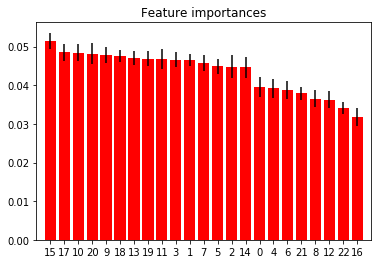

In [136]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)

X = dataset.iloc[:, 1:24]   #X =  23 features
y = dataset.iloc[:, 0]      #y = target feature, TotalConsmp

#fit forest to our data to find level of importance of features
forest.fit(X, y)
importances = forest.feature_importances_    #The feature importances (the higher, the more important the feature). 
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
captured_indices = indices[:15]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
pyplot.figure()
pyplot.title("Feature importances")
pyplot.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
pyplot.xticks(range(X.shape[1]), indices)
pyplot.xlim([-1, X.shape[1]])
pyplot.show()   
#extract the top 15 features to test on
df = pd.DataFrame(dataset.TotalConsmp)
for f in range(15):
    df[dataset.columns[indices[f]]]= dataset.iloc[:,indices[f]]

## Random Forest Regressor

In an attempt to use some methods of feature extraction made by the Mars Express Power Challenge team, we will also examine how a random forest regressor extracts features from our data and compare it to the results from the extra tree classifier. 

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression


regr = RandomForestRegressor(max_depth=2, random_state=0,
                              n_estimators=100)
#X and y are the same as above
regr.fit(X, y) 
feat_imp = regr.feature_importances_
#predict results
print(regr.predict([np.zeros(23)]))
#capture indices of top 15 features
index_list = list(feat_imp.argsort()[-15:][::-1])
#extract the top 15 features to test on
df2 = pd.DataFrame(dataset.TotalConsmp)
for index in index_list:
    df2[dataset.columns[index]] = dataset.iloc[:, index]
df2.head()

[134.25457185]


,TotalConsmp,Press_mm_hg,R1,R3,R5,H_1,H_2,R2,R6,R7,H_OutSide,H_8,R9,H_6,TempOutSide,R4
date,,,,,,,,,,,,,,,,
1/11/2016 17:00,90,733.5,19.89,19.79,17.166667,47.596667,44.790000,19.2,7.026667,17.200000,92.0,48.900000,17.033333,84.256667,6.60,19.000000
1/11/2016 17:10,90,733.6,19.89,19.79,17.166667,46.693333,44.722500,19.2,6.833333,17.200000,92.0,48.863333,17.066667,84.063333,6.48,19.000000
1/11/2016 17:20,80,733.7,19.89,19.79,17.166667,46.300000,44.626667,19.2,6.560000,17.200000,92.0,48.730000,17.000000,83.156667,6.37,18.926667
1/11/2016 17:30,90,733.8,19.89,19.79,17.166667,46.066667,44.590000,19.2,6.433333,17.133333,92.0,48.590000,17.000000,83.423333,6.25,18.890000
1/11/2016 17:40,100,733.9,19.89,19.79,17.200000,46.333333,44.530000,19.2,6.366667,17.200000,92.0,48.590000,17.000000,84.893333,6.13,18.890000


### Compare Feature Extraction Methods

We have collected two subsets of 15 features. Let's see how they compare to each other using a Venn diagram, and select the intersection of both sets for further testing.

,TotalConsmp,R1,H_1,R2,R3,R4,R5,R6,R7,R9,TempOutSide,Press_mm_hg
date,,,,,,,,,,,,
1/11/2016 17:00,90,19.89,47.596667,19.2,19.79,19.000000,17.166667,7.026667,17.200000,17.033333,6.60,733.5
1/11/2016 17:10,90,19.89,46.693333,19.2,19.79,19.000000,17.166667,6.833333,17.200000,17.066667,6.48,733.6
1/11/2016 17:20,80,19.89,46.300000,19.2,19.79,18.926667,17.166667,6.560000,17.200000,17.000000,6.37,733.7
1/11/2016 17:30,90,19.89,46.066667,19.2,19.79,18.890000,17.166667,6.433333,17.133333,17.000000,6.25,733.8
1/11/2016 17:40,100,19.89,46.333333,19.2,19.79,18.890000,17.200000,6.366667,17.200000,17.000000,6.13,733.9


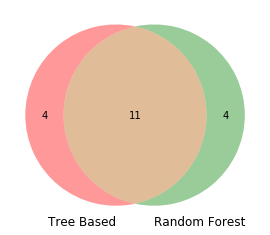

In [156]:
from matplotlib_venn import venn2, venn3, venn2_circles

#venn diagram of features selected from A=Tree Based Classifier and B = Random Forest Regressor
venn2([set(captured_indices), set(index_list)], set_labels= ('Tree Based','Random Forest'))

intersection = set(captured_indices).intersection(set(index_list))
A_minus_B = set(captured_indices).difference(index_list)
B_minus_A = set(index_list).difference(captured_indices)

#Create a dataframe with indices from the two selections' intersection
df3 = pd.DataFrame(dataset.TotalConsmp)
for index in intersection:
    df3[dataset.columns[index]] = dataset.iloc[:, index]
df3.head()

In [215]:
#Run model on all 3 subsets of features
feature_1_scores = [] #test RMSE for df
feature_2_scores = [] #test RMSE for df2
feature_3_scores = [] #test RMSE for df3
for i in range(3):
    feature_1 = network(df, 13800, n_features=16, lookback=1, epoch=50)
    feature_2 =  network(df2,13800,n_features=16,epoch=50)
    feature_3 =  network(df3,13800,n_features=12,epoch=50)
    feature_1_scores.append(feature_1[0])
    feature_2_scores.append(feature_2[0])
    feature_3_scores.append(feature_3[0])
#output hidden to decrease lines of code, but summarized in following cell  
#this was run a number of times to determine a best model, not all trials are shown for sake of brevity

In [214]:
feature_1_scores, feature_2_scores, feature_3_scores

([11.798458735785749, 2.7037788438250487, 7.785351511051686],
 [8.34119984949403, 4.192745965192465, 3.0200535962736215],
 [4.1414423297835325, 3.04577460347621, 6.511263258758128])

### Interpret Results 

After running the model several times on df,df2, and df3, the best results consistantly came from df2, the dataset with features extracted from RandomForestClassifier. The model produced the lowest amount of variance, consistantly produced lower RMSE scores than the data from df, and produced similarly good results to the data from df3 with less variance. Therefore we will use df2 as our training set from here on out. 

### How Much Variance Do We Really Have?

It is important to understand how much variance is present in our chosen model, as this will have an impact on how we enterpret our results, and how we vary our parameters in the future to help balance the variance - bias trade off.

In [210]:
df2_scores = []
for i in range(20):
    feature = network(df2, 13800, n_features=16, lookback=1, epoch=50)
    df2_scores.append(feature[0])
    i+=i
mean = df2_scores.mean()
variance = df2_scores.var()

#output hidden to decrease lines of code, but summarized in following cell   

The mean of the error scores is 5.222 and the variance is 4.516.


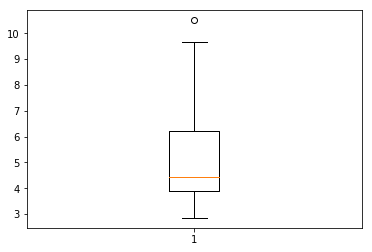

In [208]:
from statistics import mean, variance
mean = mean(df2_scores)
variance = variance(df2_scores)


print('The mean of the error scores is %.3f and the variance is %.3f.'%(mean, variance))
pyplot.boxplot(df2_scores)
pyplot.show()

### Running our model on different aggregates

We will run our model on the following aggregates:

    -unaggregated data
    
    -aggregated hourly
    
    -aggregated daily


(19734, 24)
(13800, 24) 13800 (13800,)
(13800, 1, 24) (13800,) (5934, 1, 24) (5934,)
Train on 13800 samples, validate on 5934 samples
Epoch 1/50
 - 14s - loss: 0.0456 - val_loss: 0.0466
Epoch 2/50
 - 2s - loss: 0.0266 - val_loss: 0.0191
Epoch 3/50
 - 1s - loss: 0.0133 - val_loss: 0.0252
Epoch 4/50
 - 1s - loss: 0.0122 - val_loss: 0.0173
Epoch 5/50
 - 1s - loss: 0.0128 - val_loss: 0.0208
Epoch 6/50
 - 1s - loss: 0.0071 - val_loss: 0.0083
Epoch 7/50
 - 1s - loss: 0.0076 - val_loss: 0.0080
Epoch 8/50
 - 1s - loss: 0.0073 - val_loss: 0.0061
Epoch 9/50
 - 1s - loss: 0.0049 - val_loss: 0.0059
Epoch 10/50
 - 1s - loss: 0.0071 - val_loss: 0.0063
Epoch 11/50
 - 1s - loss: 0.0076 - val_loss: 0.0032
Epoch 12/50
 - 1s - loss: 0.0034 - val_loss: 0.0032
Epoch 13/50
 - 1s - loss: 0.0056 - val_loss: 0.0024
Epoch 14/50
 - 1s - loss: 0.0032 - val_loss: 0.0037
Epoch 15/50
 - 1s - loss: 0.0035 - val_loss: 0.0048
Epoch 16/50
 - 1s - loss: 0.0039 - val_loss: 0.0058
Epoch 17/50
 - 1s - loss: 0.0059 - val_los

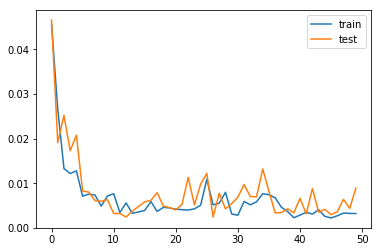

Test RMSE: 10.837
Train RMSE: 12.059


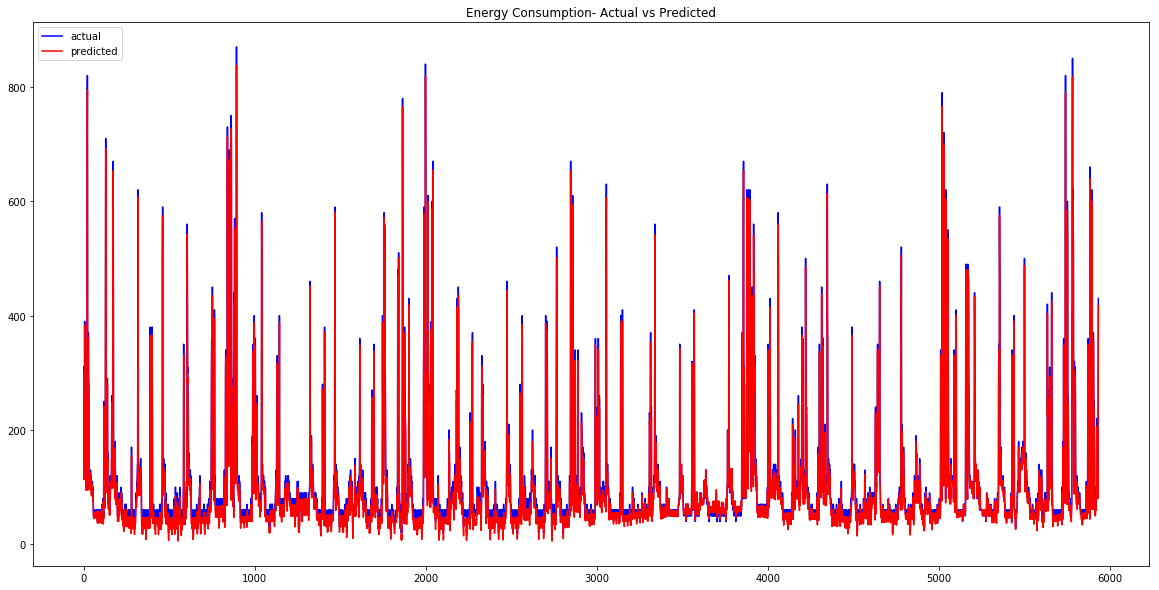

In [183]:
#run the neural network function on our unaggregated, full-featured data
unaggregated = network(dataset, 13800, n_features=24 , lookback=1, epoch=50)
plot_forecast(unaggregated)

(3289, 16)
(2303, 16) 2303 (2303,)
(2303, 1, 16) (2303,) (986, 1, 16) (986,)
Train on 2303 samples, validate on 986 samples
Epoch 1/50
 - 12s - loss: 0.0962 - val_loss: 0.0680
Epoch 2/50
 - 0s - loss: 0.0874 - val_loss: 0.0622
Epoch 3/50
 - 0s - loss: 0.0784 - val_loss: 0.0609
Epoch 4/50
 - 0s - loss: 0.0675 - val_loss: 0.0486
Epoch 5/50
 - 0s - loss: 0.0549 - val_loss: 0.0388
Epoch 6/50
 - 0s - loss: 0.0415 - val_loss: 0.0299
Epoch 7/50
 - 0s - loss: 0.0320 - val_loss: 0.0286
Epoch 8/50
 - 0s - loss: 0.0257 - val_loss: 0.0200
Epoch 9/50
 - 0s - loss: 0.0174 - val_loss: 0.0144
Epoch 10/50
 - 0s - loss: 0.0123 - val_loss: 0.0126
Epoch 11/50
 - 0s - loss: 0.0213 - val_loss: 0.0219
Epoch 12/50
 - 0s - loss: 0.0116 - val_loss: 0.0111
Epoch 13/50
 - 0s - loss: 0.0092 - val_loss: 0.0093
Epoch 14/50
 - 0s - loss: 0.0073 - val_loss: 0.0092
Epoch 15/50
 - 0s - loss: 0.0069 - val_loss: 0.0106
Epoch 16/50
 - 0s - loss: 0.0065 - val_loss: 0.0092
Epoch 17/50
 - 0s - loss: 0.0074 - val_loss: 0.0086


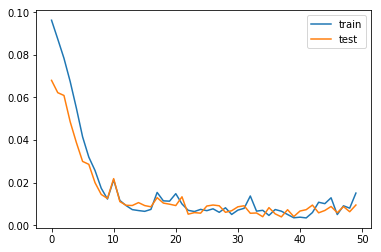

Test RMSE: 6.472
Train RMSE: 4.300


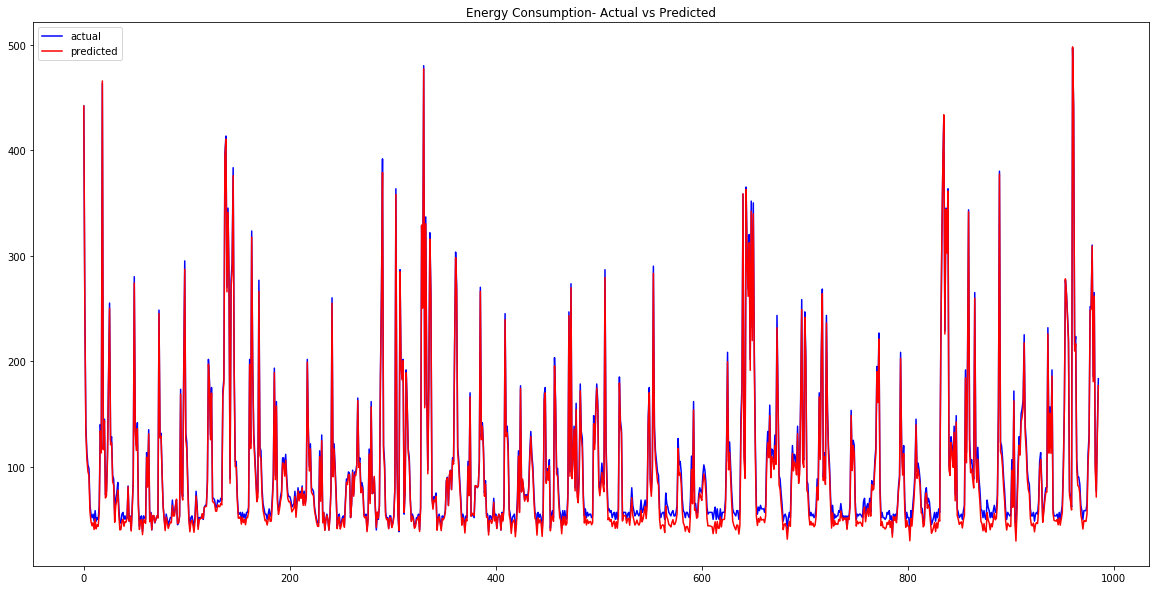

In [189]:
#aggregate data for average hourly readings
df2.index =  pd.to_datetime(df2.index)
#average hourly features
hourly = df2.resample('H').mean()
hourly.info()
hourly_forecast = network(hourly,int(3290*.7),n_features=16)
plot_forecast(hourly_forecast)

(137, 16)
(89, 16) 89 (89,)
(89, 1, 16) (89,) (48, 1, 16) (48,)
Train on 89 samples, validate on 48 samples
Epoch 1/50
 - 13s - loss: 0.3573 - val_loss: 0.2103
Epoch 2/50
 - 0s - loss: 0.2634 - val_loss: 0.1341
Epoch 3/50
 - 0s - loss: 0.2000 - val_loss: 0.1627
Epoch 4/50
 - 0s - loss: 0.1730 - val_loss: 0.2231
Epoch 5/50
 - 0s - loss: 0.1689 - val_loss: 0.2503
Epoch 6/50
 - 0s - loss: 0.1682 - val_loss: 0.2381
Epoch 7/50
 - 0s - loss: 0.1612 - val_loss: 0.2092
Epoch 8/50
 - 0s - loss: 0.1573 - val_loss: 0.1868
Epoch 9/50
 - 0s - loss: 0.1567 - val_loss: 0.1781
Epoch 10/50
 - 0s - loss: 0.1552 - val_loss: 0.1763
Epoch 11/50
 - 0s - loss: 0.1529 - val_loss: 0.1785
Epoch 12/50
 - 0s - loss: 0.1502 - val_loss: 0.1819
Epoch 13/50
 - 0s - loss: 0.1475 - val_loss: 0.1810
Epoch 14/50
 - 0s - loss: 0.1448 - val_loss: 0.1740
Epoch 15/50
 - 0s - loss: 0.1425 - val_loss: 0.1691
Epoch 16/50
 - 0s - loss: 0.1401 - val_loss: 0.1670
Epoch 17/50
 - 0s - loss: 0.1373 - val_loss: 0.1632
Epoch 18/50
 - 0

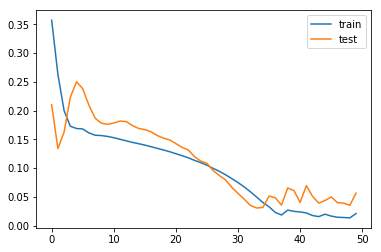

Test RMSE: 11.559
Train RMSE: 3.109


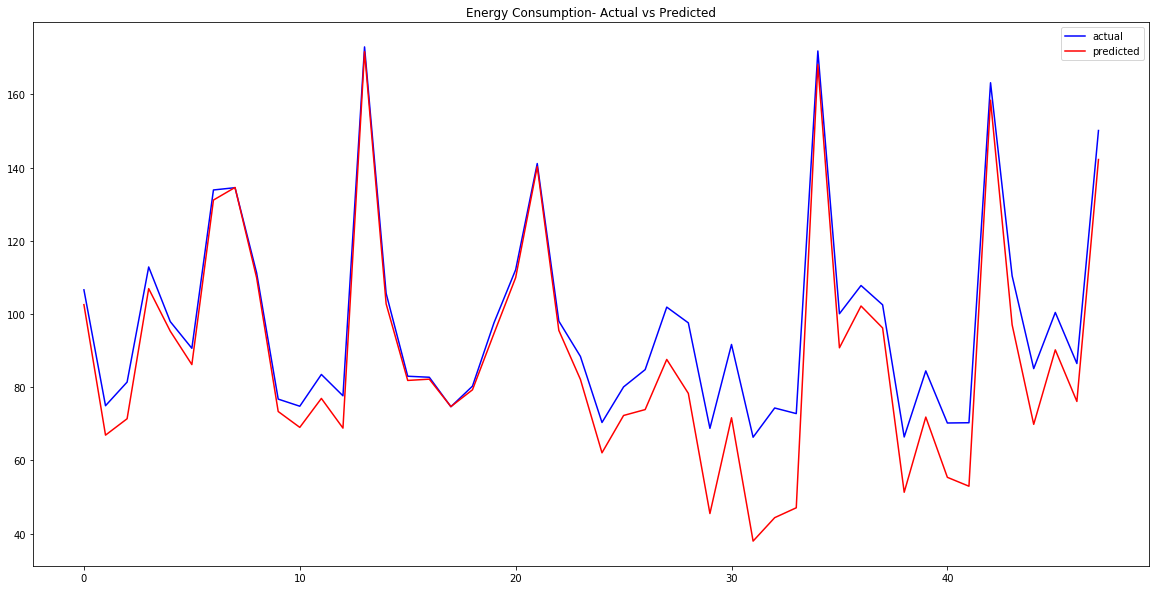

In [190]:
#Average values for features by the day
daily = df.resample('D').mean()
daily.head()
#note that we must lessen our batch size to account for less data
daily_forecast = network(daily,int(138*.65),n_features=16,batch_sz=15)
plot_forecast(daily_forecast)

### Overview of Aggregated Data in LSTM Model

Aggregating by the hour performed just about as well as unaggregated data in our neural net, however when we aggregated our data by a daily mean, the model suffered from not enough data. With only 138 samples of daily data, we struggle a bit with overfitting and just not having enough data to really learn from, regardless of the epoch parameter.



### A Closer Look at the Data

Let's take this time to digress from the LSTM model and to just analyze and visualize the data that we have. There are some interesting features that we can explore here, like energy consumption in the night time versus during the day, energy consumption on weekends vs weekdays, and so on. 

In [46]:
#Let's examine night time data vs day time data
#nightime data
hours = df.index.hour
mask = (hours >= 18) & (hours <=23)
nighttime = df[mask].groupby(df[mask].index.floor('D')).mean()
nighttime.WeekdayName = nighttime.index.weekday
#daytime data
hours_day = df.index.hour
mask_day = (hours >= 5) & (hours <=12)
daytime = df[mask_day].groupby(df[mask_day].index.floor('D')).mean()
daytime.WeekdayName = daytime.index.weekday
#finding the difference between night time and day time consumption
difference = nighttime - daytime

### Plots of Consumption by Day for Daytime vs Nighttime Usage

We can clearly see much more variance in daytime hours as opposed to night time hours.
Most days dont seem to have too many outliers, except you can note that Friday night has some extreme outlier(s). It would be interesting to check the date of these outliers against a log of cruise activity to glean insight as to what caused these spikes in consumption. Or if it appears to be an anomoly, then this data point can be removed, along with other anomolous outliers.



Text(0.5, 1.0, 'Nighttime Weekday Consumption')

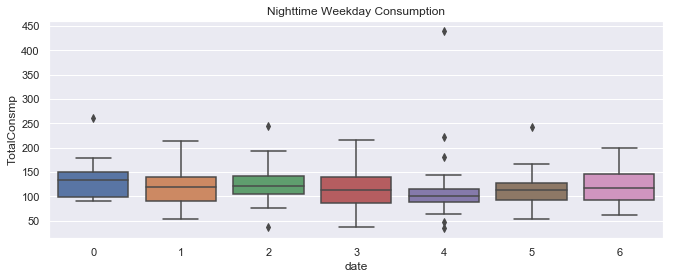

In [60]:
sns.set(rc={'figure.figsize':(11, 4)})
#boxplot of consumption by day for nighttime usage
sns.boxplot(data=nighttime, x=nighttime.WeekdayName, y=nighttime.TotalConsmp).set_title('Nighttime Weekday Consumption')

Text(0.5, 1.0, 'Daytime Weekday Consumption')

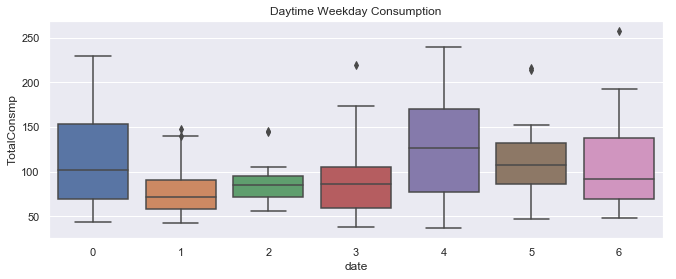

In [61]:
#boxplot of consumption by day for daytime usage
sns.boxplot(data=daytime, x=daytime.WeekdayName, y=daytime.TotalConsmp).set_title('Daytime Weekday Consumption')

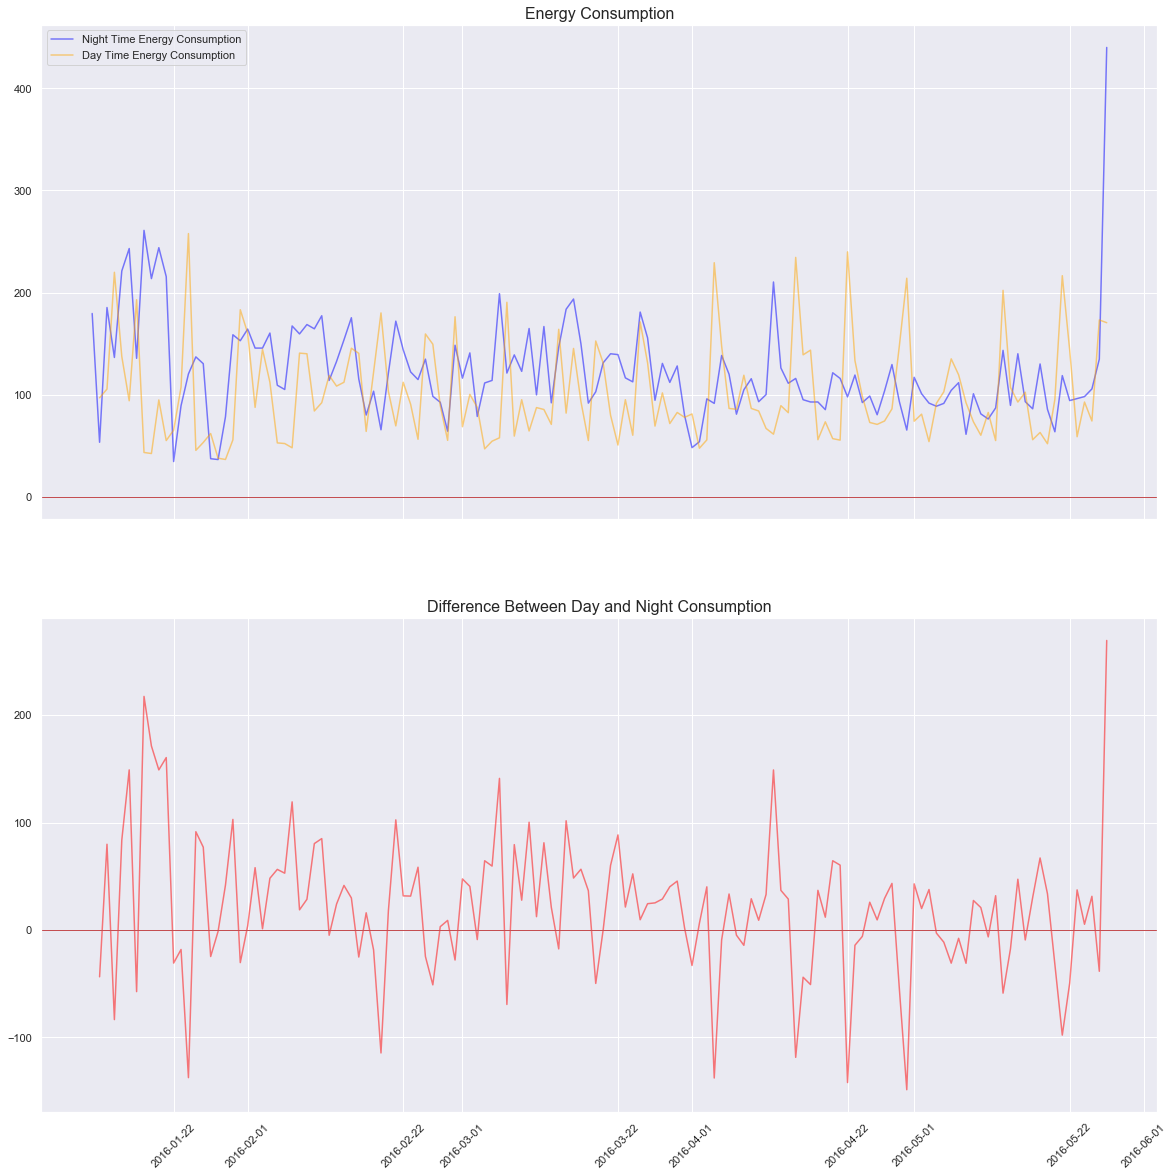

In [63]:
#Plot 2 subplots, one comparing day and night data and one examining the difference
fig, axes = pyplot.subplots(nrows=2, ncols=1, sharex=True, figsize=(20, 20))

axes[0].set_title('Energy Consumption', fontsize=16)
axes[1].set_title('Difference Between Day and Night Consumption', fontsize=16)

axes[0].plot(nighttime.TotalConsmp, color='blue', alpha=.5, label='Night Time Energy Consumption')
axes[0].plot(daytime.TotalConsmp, color='orange', alpha =.5, label='Day Time Energy Consumption')
axes[1].plot(difference.TotalConsmp, color='red', alpha =.5, label='Difference')
pyplot.xticks(rotation=45)
axes[0].legend()
axes[1].legend
axes[0].axhline(linewidth=1, color='r')
axes[1].axhline(linewidth=1, color='r')





In [64]:
'''
Perhaps we are curious to see on what days is more energy used during the night time?
Let's take a look
'''

#find the weekdays with more nightime consumption than daytime
morenight = difference[difference.TotalConsmp >0].index.weekday
morenight = list(morenight)
morenight_dict = {}
for i in range(7):
    x = morenight.count(i)
    morenight_dict[i]= x
    
morenight_dict
#We can see that Tuesday and Wednesday have the most days with elevated nighttime usage


{0: 14, 1: 17, 2: 17, 3: 12, 4: 8, 5: 11, 6: 12}

### Conclusion and Next Steps

Our objective at the start of this experiment was to write a model that could accurately predict energy consumption based on multivariate time series data. Through extensive feature extraction and using a LSTM recurrent neural network, this objective was satisfied to a certain degree of accuracy. The appropriate next steps in this project would be to fine tune our hyper parameters even more to maintain higher levels of accuracy, and to consider the bias-variance trade off that we currently have in our model and to see if this ratio needs to be altered. Right now we have a not-insignificant level of variance (approx. 3-10%, given which data we run the model on). One must ask herself, is this an appropriate amount of variance, or do we add bias in order to fix this problem. An article that seems to do a great job of addressing adding bias to LSTMs can be found [here](http://proceedings.mlr.press/v37/jozefowicz15.pdf); I would take it as a next step to ingest this information along with other options for fine tuning an LSTM and give these methods a try to see if we can achieve improved results. In addition to tuning the current model, another appropriate next step would be to contextualize the data with the business needs and additional business data. For example, I would look at my weekday data aggregated by daytime and nighttime and I would compare energy consumption with activities happening on the ship, i.e. were we docked at port that day, were there big events taking place, where we we at sea, etc. This will help the company glean more insight to how to actually use their energy predictions and help cut down on energy expenditure. 